# Demo for jet.JetEvents class

This `ipynb` will demonstrate how to use the defined class `jet.JetEvents` in `jet.py`. We will show how to create and extract information from `jet.JetEvents` class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

# HEP tools
import uproot
import awkward as ak
import jet

num_events = 1000 #must be match to the existed root files name
data_path = "/Users/yianchen/CMS_Open_Data_Workspace/CMSSW_7_6_7/src/QCD_Jet_Fatjet/Analyzer/root_files/"
channels = [
    "ZprimeToZhToZinvhbb",
    "ZprimeToZhToZlephbb",
    "QCD_HT1500to2000",
    "QCD_HT2000toInf",
]

# set up jet.JetEvents class for jets and fatjets
jet_events = []
fatjet_events = []
for i in range(len(channels)):
    channel = channels[i]
    root_file = f"{data_path}{channel}_{num_events}.root"
    uproot_file = uproot.open(root_file)
    events = uproot_file['jets/Events']
    jet_pt = jet.JetEvents(events, jet_type="jet", keep_by="pt")
    fatjet_pt = jet.JetEvents(events, jet_type="fatjet", keep_by="pt")
    jet_events.append(jet_pt)
    fatjet_events.append(fatjet_pt)

### Particles/Anti-Particles distribution of events

Plot the constituent in pie chart for each channel.

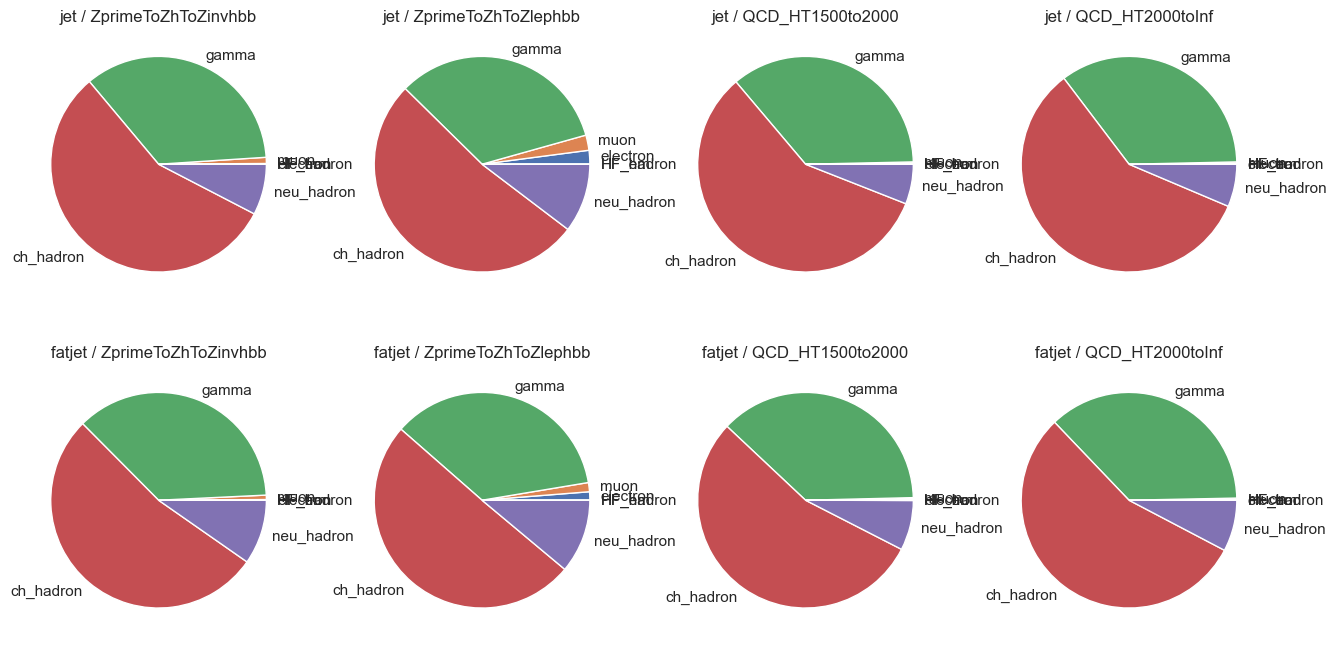

In [2]:
# the 1st row is jet, and the 2nd row is fatjet
fig, ax = plt.subplots(2, len(channels), figsize=(4*len(channels), 2*4), facecolor="white")

def draw_constituent(single_ax, events):
    daughter = events.daughter
    single_ax.pie(
        x = [
            ak.sum(daughter["electron"]), ak.sum(daughter["muon"]), ak.sum(daughter["gamma"]),
            ak.sum(daughter["ch_hadron"]), ak.sum(daughter["neu_hadron"]),
            ak.sum(daughter["HF_hadron"]), ak.sum(daughter["HF_em"])
        ],
        labels = [
            "electron", "muon", "gamma",
            "ch_hadron", "neu_hadron", "HF_hadron", "HF_em"
            ]
    )

for i in range(len(channels)):
    draw_constituent(ax[0][i], jet_events[i])
    draw_constituent(ax[1][i], fatjet_events[i])
    ax[0][i].set_title(f"jet / {channels[i]}")
    ax[1][i].set_title(f"fatjet / {channels[i]}")

### N-subjettiness of fatjets
plot `tau1`, `tau2`, `tau3`, `tau2/tau1`, `tau3/tau2`

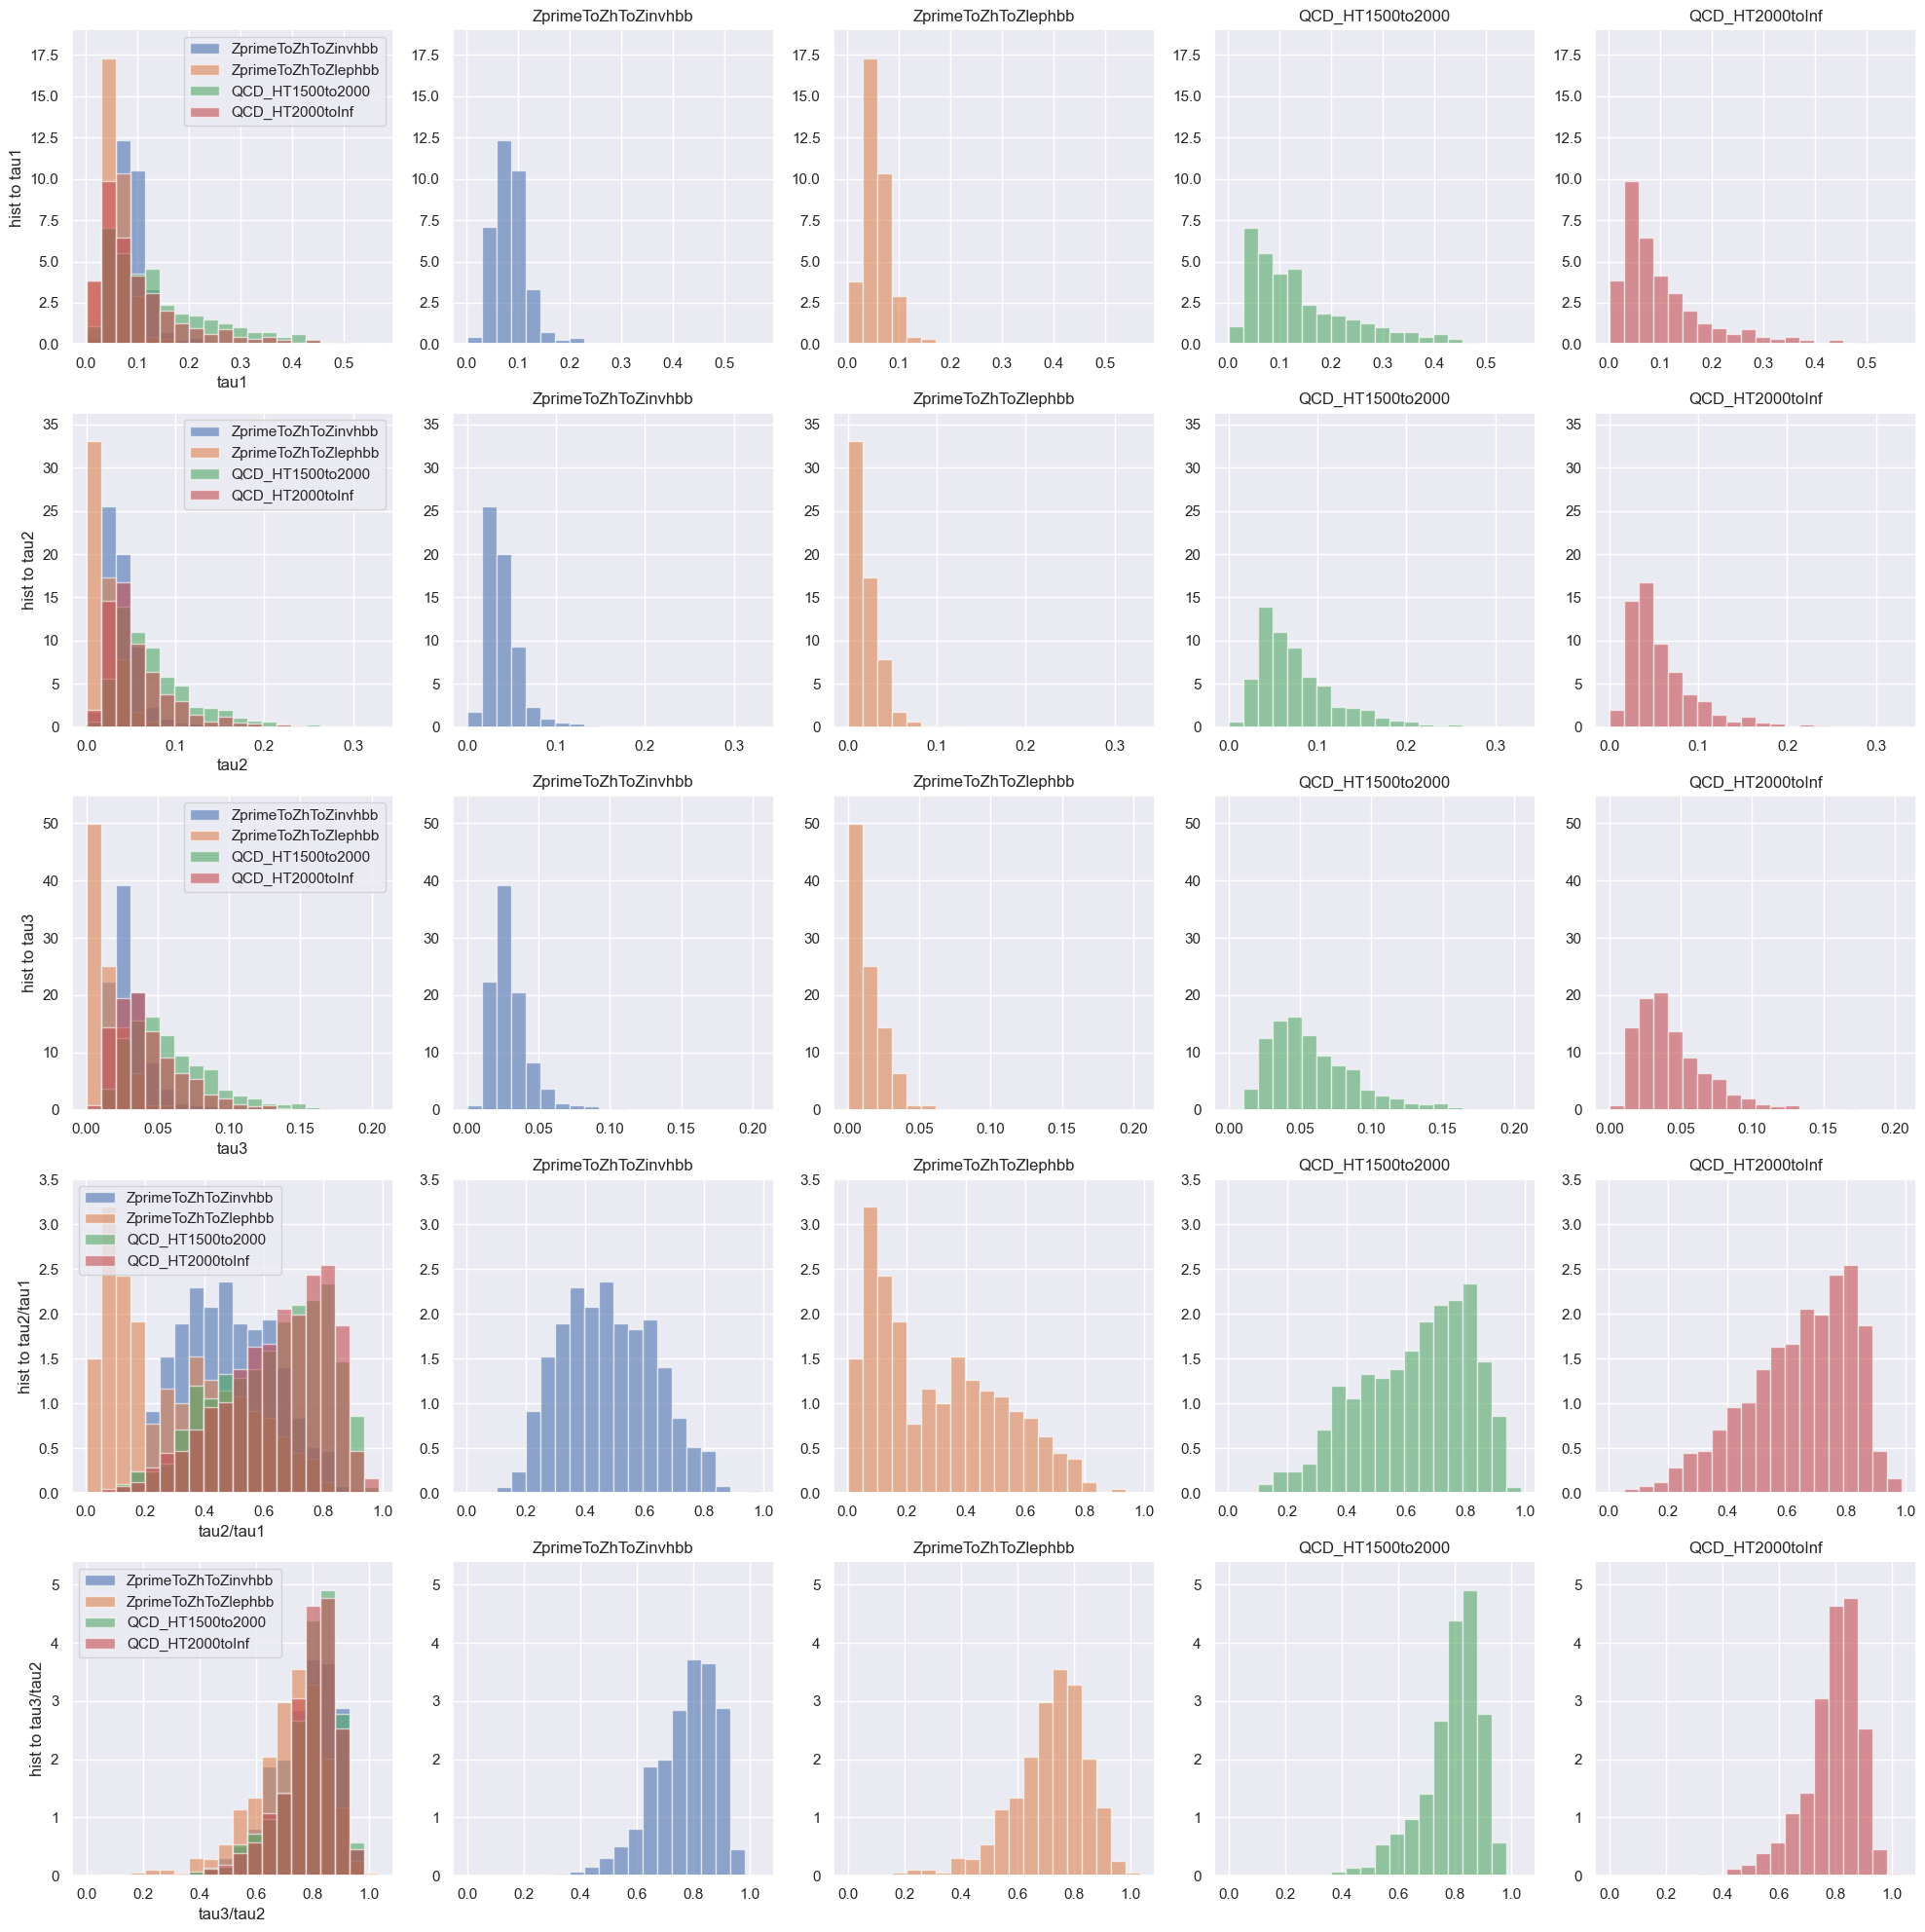

In [3]:
# the 1st row is tau1, the 2nd row is tau2, and the 3rd row is tau3
# the 4th row is tau2/tau1, and the 5th row is tau3/tau2
fig, ax = plt.subplots(5,len(channels)+1,figsize=((len(channels)+1)*4, 5*4))

def draw_nsubjettiness(row_ax, tau, bins):
    if "/" not in tau:
        xrange = [
            min([ak.min(events.nsubjettiness[f"{tau}"]) for events in fatjet_events]),
            max([ak.max(events.nsubjettiness[f"{tau}"]) for events in fatjet_events]),
        ]
    else:
        tau_a, tau_b = tau.split("/")
        xrange = [
            min([ak.min(events.nsubjettiness[f"{tau_a}"] / events.nsubjettiness[f"{tau_b}"]) for events in fatjet_events]),
            max([ak.max(events.nsubjettiness[f"{tau_a}"] / events.nsubjettiness[f"{tau_b}"]) for events in fatjet_events]),
        ]
    yrange = [0,0]

    for i in range(len(channels)):
        events = fatjet_events[i]
        if "/" not in tau:
            data = ak.to_numpy(events.nsubjettiness[f"{tau}"])
        else:
            tau_a, tau_b = tau.split("/")
            data = ak.to_numpy(events.nsubjettiness[f"{tau_a}"] / events.nsubjettiness[f"{tau_b}"])
        row_ax[i+1].hist(data, bins=bins, label=channels[i], range=xrange, 
                        alpha=0.6, density=True, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        pdf, _, _ = row_ax[0].hist(data, bins=bins, label=channels[i], range=xrange, 
                        alpha=0.6, density=True, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        yrange[1] = max(yrange[1], max(pdf))
    yrange[1] *= 1.1
    row_ax[0].set_xlabel(f"{tau}")
    row_ax[0].set_ylabel(f"hist to {tau}")
    row_ax[0].set_ylim(yrange)
    row_ax[0].legend()
    for i in range(len(channels)):
        row_ax[i+1].set_title(channels[i])
        row_ax[i+1].set_ylim(yrange)

draw_nsubjettiness(ax[0], "tau1", bins=20)
draw_nsubjettiness(ax[1], "tau2", bins=20)
draw_nsubjettiness(ax[2], "tau3", bins=20)
draw_nsubjettiness(ax[3], "tau2/tau1", bins=20)
draw_nsubjettiness(ax[4], "tau3/tau2", bins=20)
plt.tight_layout()

### Pt, eta, phi distribution of jets or fatjets

Plot `Pt`, `eta`, `phi` of individual jet and fatjet, not individual particles or anti particles

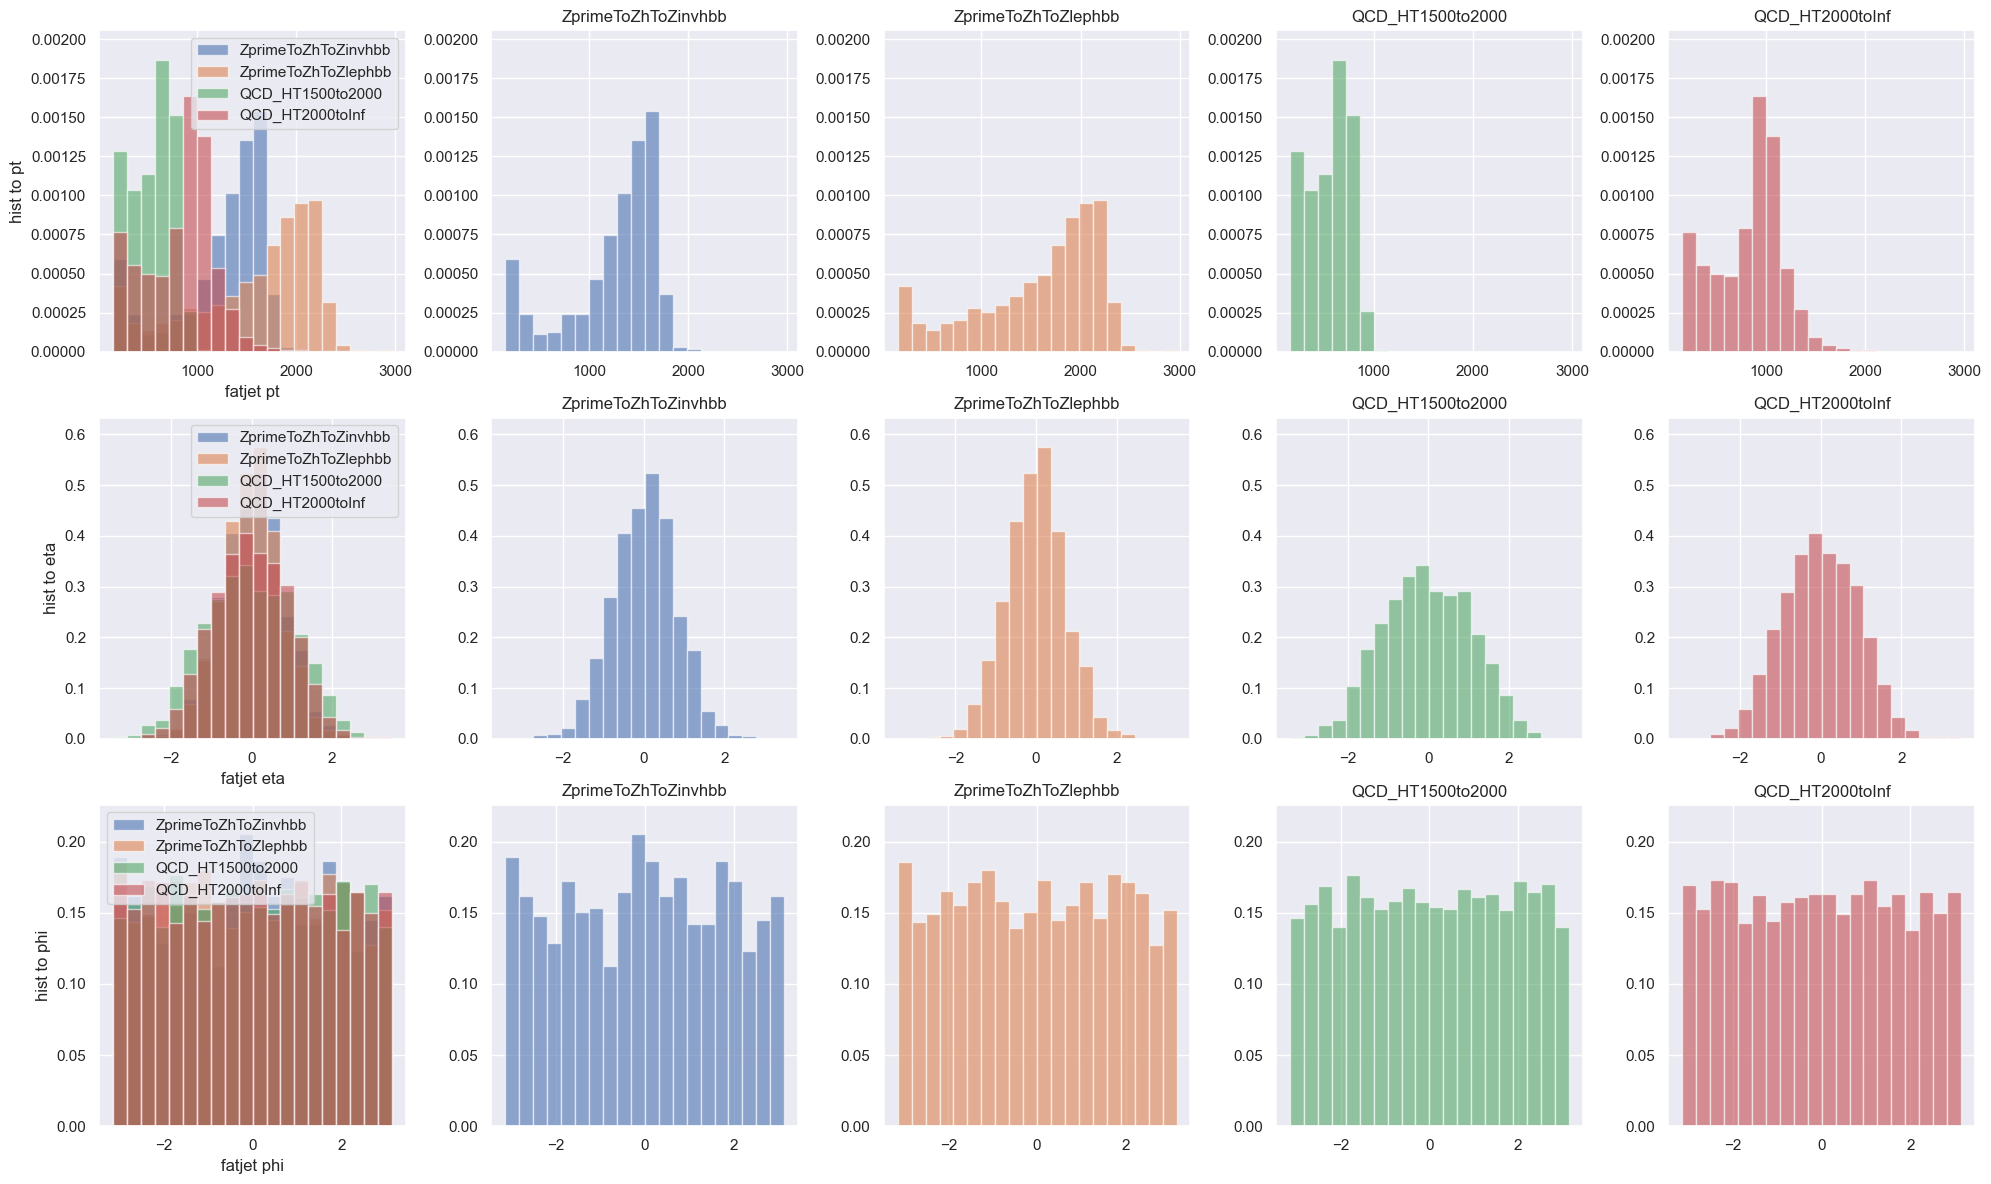

In [4]:
# the 1st row is pt, the 2nd row is eta, and the 3rd row is phi
fig, ax = plt.subplots(3,len(channels)+1,figsize=((len(channels)+1)*4, 3*4))

def draw_daughter_distribution(row_ax, feature, bins, xrange=None, jet_type="fatjet"):
    if xrange == None:
        xrange = [
            min([ak.min(events.events[f"{jet_type}_{feature}"].array()) for events in fatjet_events]),
            max([ak.max(events.events[f"{jet_type}_{feature}"].array()) for events in fatjet_events]),
        ]
    yrange = [0,0]
    for i in range(len(channels)):
        events = fatjet_events[i]
        data = ak.to_numpy(ak.flatten(events.events[f"{jet_type}_{feature}"].array()))
        row_ax[i+1].hist(data, bins=bins, label=channels[i], range=xrange, 
                    alpha=0.6, density=True, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        pdf, _, _ = row_ax[0].hist(data, bins=bins, label=channels[i], range=xrange, 
                    alpha=0.6, density=True)
        yrange[1] = max(yrange[1], max(pdf))
    yrange[1] *= 1.1
    for i in range(len(channels)):
        row_ax[0].set_xlabel(f"{jet_type} {feature}")
        row_ax[0].set_ylabel(f"hist to {feature}")
        row_ax[0].set_ylim(yrange)
        row_ax[0].legend()
        row_ax[i+1].set_title(channels[i])
        row_ax[i+1].set_ylim(yrange)
        
draw_daughter_distribution(ax[0], "pt", bins=20)
draw_daughter_distribution(ax[1], "eta", bins=20)
draw_daughter_distribution(ax[2], "phi", bins=20)
plt.tight_layout()